# This network demonstrates how to use LIME with recurrent neural networks.

This focuses on keras-style "stateless" recurrent neural networks. These networks expect input with a shape `(n_samples, n_timesteps, n_features)` as opposed to the more normal `(n_samples, n_features)` input that most other machine learning algorithms expect. 

To explain the neural network models, we use a variant on the `TabularExplainer` that takes care of reshaping data appropriately.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lime import lime_tabular

%matplotlib inline

Using Theano backend.


## Data

We will use the $CO_2$ dataset, which measures the concentration of $CO_2$ above Mauna Loa every week since about 1960. The classification task will be deciding if the concentration is rising - this is a problem that needs recurrency to solve (since the answer comes from the derivative), and is less trivial than it sounds because there is noise in the data. 

The data is included in the `data` subdirectory here, where I've added a column for the detrended data that ends up being useful for the network, as we shall see shortly.

In [2]:
df = pd.read_csv('data/co2_data.csv', index_col=0, parse_dates=True)

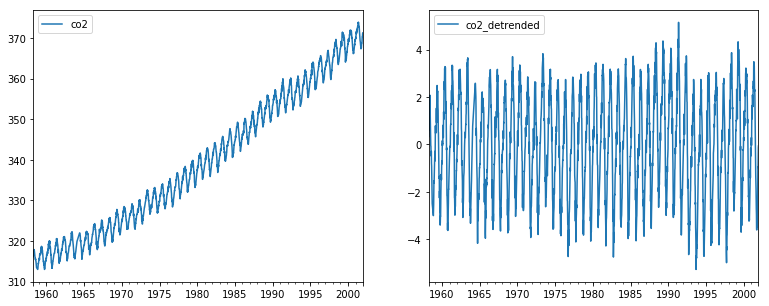

In [3]:
fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
df[['co2']].plot(ax=left)
df[['co2_detrended']].plot(ax=right)

### Reshaping the dataset to be appropriate for the model

In [4]:
def reshape_data(seq, n_timesteps):
    N = len(seq) - n_timesteps - 1
    nf = seq.shape[1]
    if N <= 0:
        raise ValueError('I need more data!')
    new_seq = np.zeros((N, n_timesteps, nf))
    for i in range(N):
        new_seq[i, :, :] = seq[i:i+n_timesteps]
    return new_seq

In [5]:
N_TIMESTEPS = 12  # Use 1 year of lookback
data_columns = ['co2', 'co2_detrended']
target_columns = ['rising']

scaler = MinMaxScaler(feature_range=(-1, 1))
X_original = scaler.fit_transform(df[data_columns].values)
X = reshape_data(X_original, n_timesteps=N_TIMESTEPS)
y = to_categorical((df[target_columns].values[N_TIMESTEPS:-1]).astype(int))

# Train on the first 2000, and test on the last 276 samples
X_train = X[:2000]
y_train = y[:2000]
X_test = X[2000:]
y_test = y[2000:]
print(X.shape, y.shape)

(2270, 12, 2) (2270, 2)


# Define the model

In [6]:
model = Sequential()
model.add(LSTM(32, input_shape=(N_TIMESTEPS, len(data_columns))))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

optimizer = Adam(lr=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [7]:
model.fit(X_train, y_train, batch_size=100, epochs=500,
          validation_data=(X_test, y_test),
          verbose=2)

Train on 2000 samples, validate on 270 samples
Epoch 1/500
0s - loss: 0.7026 - val_loss: 0.6739
Epoch 2/500
0s - loss: 0.6883 - val_loss: 0.6651
Epoch 3/500
0s - loss: 0.6748 - val_loss: 0.6558
Epoch 4/500
0s - loss: 0.6636 - val_loss: 0.6457
Epoch 5/500
0s - loss: 0.6485 - val_loss: 0.6352
Epoch 6/500
0s - loss: 0.6335 - val_loss: 0.6236
Epoch 7/500
0s - loss: 0.6172 - val_loss: 0.6108
Epoch 8/500
0s - loss: 0.6013 - val_loss: 0.5964
Epoch 9/500
0s - loss: 0.5822 - val_loss: 0.5806
Epoch 10/500
0s - loss: 0.5621 - val_loss: 0.5633
Epoch 11/500
0s - loss: 0.5402 - val_loss: 0.5441
Epoch 12/500
0s - loss: 0.5149 - val_loss: 0.5234
Epoch 13/500
0s - loss: 0.4914 - val_loss: 0.5013
Epoch 14/500
0s - loss: 0.4668 - val_loss: 0.4788
Epoch 15/500
0s - loss: 0.4444 - val_loss: 0.4574
Epoch 16/500
0s - loss: 0.4219 - val_loss: 0.4365
Epoch 17/500
0s - loss: 0.4034 - val_loss: 0.4176
Epoch 18/500
0s - loss: 0.3851 - val_loss: 0.4012
Epoch 19/500
0s - loss: 0.3705 - val_loss: 0.3861
Epoch 20/500

0s - loss: 0.1958 - val_loss: 0.2387
Epoch 164/500
0s - loss: 0.1930 - val_loss: 0.2375
Epoch 165/500
0s - loss: 0.1913 - val_loss: 0.2376
Epoch 166/500
0s - loss: 0.1909 - val_loss: 0.2375
Epoch 167/500
0s - loss: 0.1910 - val_loss: 0.2369
Epoch 168/500
0s - loss: 0.1926 - val_loss: 0.2359
Epoch 169/500
0s - loss: 0.1907 - val_loss: 0.2354
Epoch 170/500
0s - loss: 0.1938 - val_loss: 0.2365
Epoch 171/500
0s - loss: 0.1920 - val_loss: 0.2354
Epoch 172/500
0s - loss: 0.1903 - val_loss: 0.2349
Epoch 173/500
0s - loss: 0.1919 - val_loss: 0.2361
Epoch 174/500
0s - loss: 0.1950 - val_loss: 0.2379
Epoch 175/500
0s - loss: 0.1884 - val_loss: 0.2352
Epoch 176/500
0s - loss: 0.1918 - val_loss: 0.2357
Epoch 177/500
0s - loss: 0.1911 - val_loss: 0.2372
Epoch 178/500
0s - loss: 0.1901 - val_loss: 0.2364
Epoch 179/500
0s - loss: 0.1914 - val_loss: 0.2365
Epoch 180/500
0s - loss: 0.1912 - val_loss: 0.2357
Epoch 181/500
0s - loss: 0.1918 - val_loss: 0.2352
Epoch 182/500
0s - loss: 0.1895 - val_loss: 0

0s - loss: 0.1858 - val_loss: 0.2264
Epoch 325/500
0s - loss: 0.1864 - val_loss: 0.2270
Epoch 326/500
0s - loss: 0.1877 - val_loss: 0.2270
Epoch 327/500
0s - loss: 0.1891 - val_loss: 0.2284
Epoch 328/500
0s - loss: 0.1869 - val_loss: 0.2271
Epoch 329/500
0s - loss: 0.1905 - val_loss: 0.2282
Epoch 330/500
0s - loss: 0.1860 - val_loss: 0.2268
Epoch 331/500
0s - loss: 0.1865 - val_loss: 0.2276
Epoch 332/500
0s - loss: 0.1881 - val_loss: 0.2297
Epoch 333/500
0s - loss: 0.1877 - val_loss: 0.2258
Epoch 334/500
0s - loss: 0.1878 - val_loss: 0.2274
Epoch 335/500
0s - loss: 0.1892 - val_loss: 0.2262
Epoch 336/500
0s - loss: 0.1865 - val_loss: 0.2278
Epoch 337/500
0s - loss: 0.1877 - val_loss: 0.2278
Epoch 338/500
0s - loss: 0.1859 - val_loss: 0.2285
Epoch 339/500
0s - loss: 0.1884 - val_loss: 0.2273
Epoch 340/500
0s - loss: 0.1899 - val_loss: 0.2281
Epoch 341/500
0s - loss: 0.1890 - val_loss: 0.2274
Epoch 342/500
0s - loss: 0.1911 - val_loss: 0.2277
Epoch 343/500
0s - loss: 0.1862 - val_loss: 0

0s - loss: 0.1908 - val_loss: 0.2294
Epoch 486/500
0s - loss: 0.1812 - val_loss: 0.2276
Epoch 487/500
0s - loss: 0.1837 - val_loss: 0.2296
Epoch 488/500
0s - loss: 0.1836 - val_loss: 0.2288
Epoch 489/500
0s - loss: 0.1854 - val_loss: 0.2290
Epoch 490/500
0s - loss: 0.1875 - val_loss: 0.2272
Epoch 491/500
0s - loss: 0.1839 - val_loss: 0.2285
Epoch 492/500
0s - loss: 0.1849 - val_loss: 0.2308
Epoch 493/500
0s - loss: 0.1846 - val_loss: 0.2289
Epoch 494/500
0s - loss: 0.1867 - val_loss: 0.2291
Epoch 495/500
0s - loss: 0.1867 - val_loss: 0.2276
Epoch 496/500
0s - loss: 0.1864 - val_loss: 0.2297
Epoch 497/500
0s - loss: 0.1845 - val_loss: 0.2307
Epoch 498/500
0s - loss: 0.1855 - val_loss: 0.2289
Epoch 499/500
0s - loss: 0.1852 - val_loss: 0.2301
Epoch 500/500
0s - loss: 0.1830 - val_loss: 0.2298


In [8]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.92      0.87       100
          1       0.95      0.89      0.92       170

avg / total       0.90      0.90      0.90       270



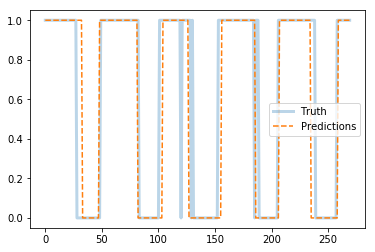

In [9]:
plt.plot(y_true, lw=3, alpha=0.3, label='Truth')
plt.plot(y_pred, '--', label='Predictions')
plt.legend(loc='best')

# Explain the model with LIME:

In [10]:
explainer = lime_tabular.RecurrentTabularExplainer(X_train, training_labels=y_train, feature_names=data_columns,
                                                   discretize_continuous=True,
                                                   class_names=['Falling', 'Rising'],
                                                   discretizer='decile')

In [12]:
exp = explainer.explain_instance(X_test[50], model.predict, num_features=10, labels=(1,))
exp.show_in_notebook()

We can see that the most important features are the de-trended $CO_2$ concentration several timesteps in the past. In particular, we see that if that feature is low in the recent past, then the concentration is now probably rising. 